In [1]:
# Cell 1: Data Loading and Preprocessing Functions


# This notebook implements a comprehensive ML model for classifying normal vs abnormal heart sounds
# using audio recordings from 4 auscultation locations and patient demographics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import pandas as pd
import numpy as np
import librosa
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

CLIP_LENGTH = 3  # seconds

class AudioPreprocessor:
    """Handles audio preprocessing including bandpass filtering and mel-spectrogram generation"""
    
    def __init__(self, sample_rate=4000, n_mels=128, n_fft=1024, hop_length=512, 
                 normalization_method='minmax'): #zscore #minmax #robust #global_stats
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.normalization_method = normalization_method

    def bandpass_filter(self, audio, lowcut=25, highcut=800):
        """Apply bandpass filter to remove noise"""
        from scipy import signal
        nyquist = 0.5 * self.sample_rate
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = signal.butter(4, [low, high], btype='band')
        return signal.filtfilt(b, a, audio)
    
    def split_into_5s_clips(self, audio, sample_rate):
        """Split audio into 5-second clips, discarding remainder"""
        clip_length = CLIP_LENGTH * sample_rate
        n_clips = len(audio) // clip_length
        clips = []
        for i in range(n_clips):
            start = i * clip_length
            end = start + clip_length
            clips.append(audio[start:end])
        return clips
    
    def audio_to_melspec(self, audio):
        """Convert audio to mel-log spectrogram"""
        # Apply bandpass filter
        filtered_audio = self.bandpass_filter(audio)
        
        # Generate mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=filtered_audio,
            sr=self.sample_rate,
            n_mels=self.n_mels,
            n_fft=self.n_fft,
            hop_length=self.hop_length
        )
        
        # Convert to log scale
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

                # Apply normalization based on chosen method
        if self.normalization_method == 'zscore':
            # Z-score normalization (zero mean, unit variance) - Most common for CNNs
            log_mel_spec = (log_mel_spec - np.mean(log_mel_spec)) / (np.std(log_mel_spec) + 1e-8)
            
        elif self.normalization_method == 'minmax':
            # Min-Max normalization to [0, 1] range
            min_val = np.min(log_mel_spec)
            max_val = np.max(log_mel_spec)
            log_mel_spec = (log_mel_spec - min_val) / (max_val - min_val + 1e-8)
            
        elif self.normalization_method == 'robust':
            # Robust normalization using percentiles (less sensitive to outliers)
            p5, p95 = np.percentile(log_mel_spec, [5, 95])
            log_mel_spec = np.clip((log_mel_spec - p5) / (p95 - p5 + 1e-8), 0, 1)
            
        elif self.normalization_method == 'global_stats':
            # Global normalization using dataset statistics (would need to be computed first)
            # This is a placeholder - you'd need to compute these stats from your training data
            # global_mean, global_std = compute_dataset_stats()  # Implement this function
            # log_mel_spec = (log_mel_spec - global_mean) / (global_std + 1e-8)
            pass
        
        # If normalization_method == 'none', no normalization is applied
        
        return log_mel_spec

    def compute_dataset_statistics(self, patients_data, num_samples=1000):
        """Compute global mean and std from a subset of the dataset for global normalization"""
        print("Computing dataset statistics for normalization...")
        
        all_spectrograms = []
        sample_count = 0
        
        for patient in tqdm(patients_data[:num_samples], desc="Computing stats"):
            if sample_count >= num_samples:
                break
                
            recordings = patient.get('recordings', {})
            for location in ['AV', 'PV', 'TV', 'MV']:
                if location in recordings:
                    for audio_file in recordings[location]:
                        try:
                            audio, sr = librosa.load(audio_file, sr=self.sample_rate)
                            clips = self.split_into_5s_clips(audio, sr)
                            
                            for clip in clips[:2]:  # Only use first 2 clips per file to save memory
                                # Apply preprocessing without normalization
                                temp_method = self.normalization_method
                                self.normalization_method = 'none'
                                mel_spec = self.audio_to_melspec(clip)
                                self.normalization_method = temp_method
                                
                                all_spectrograms.append(mel_spec)
                                sample_count += 1
                                
                                if sample_count >= num_samples:
                                    break
                            
                            if sample_count >= num_samples:
                                break
                        except Exception as e:
                            continue
                    
                    if sample_count >= num_samples:
                        break
                
                if sample_count >= num_samples:
                    break
        
        if all_spectrograms:
            # Concatenate all spectrograms and compute global statistics
            all_data = np.concatenate([spec.flatten() for spec in all_spectrograms])
            global_mean = np.mean(all_data)
            global_std = np.std(all_data)
            
            print(f"Dataset statistics computed from {len(all_spectrograms)} spectrograms:")
            print(f"Global mean: {global_mean:.4f}")
            print(f"Global std: {global_std:.4f}")
            
            return global_mean, global_std
        else:
            print("Warning: No spectrograms found for statistics computation")
            return 0.0, 1.0

def parse_patient_file(file_path):
    """Parse patient .txt file to extract demographics and labels"""
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    patient_info = {}
    # Parse first line: subject_id, num_recordings, sample_rate
    first_line = lines[0].strip().split()
    patient_info['subject_id'] = first_line[0]
    patient_info['num_recordings'] = int(first_line[1])
    patient_info['sample_rate'] = int(first_line[2])
    
    # Parse recording files info
    recordings = []
    for i in range(1, patient_info['num_recordings'] + 1):
        parts = lines[i].strip().split()
        recordings.append({
            'location': parts[0],
            'hea_file': parts[1],
            'wav_file': parts[2],
            'tsv_file': parts[3]
        })
    patient_info['recordings'] = recordings
    
    # Parse metadata
    for line in lines[patient_info['num_recordings'] + 1:]:
        if line.startswith('#'):
            key_value = line[1:].strip().split(': ', 1)
            if len(key_value) == 2:
                key, value = key_value
                if value != 'nan':
                    patient_info[key.lower().replace(' ', '_')] = value
                else:
                    patient_info[key.lower().replace(' ', '_')] = None
    
    return patient_info

def load_dataset(data_dir):
    """Load entire dataset and create structured dataframe"""
    data_dir = Path(data_dir)
    patients_data = []
    
    # Get all patient .txt files
    patient_files = list(data_dir.glob("*.txt"))
    
    for patient_file in tqdm(patient_files, desc="Loading patient data"):
        try:
            patient_info = parse_patient_file(patient_file)
            
            # Extract key demographic features
            demographics = {
                'subject_id': patient_info['subject_id'],
                'age': patient_info.get('age'),
                'sex': patient_info.get('sex'),
                'height': patient_info.get('height'),
                'weight': patient_info.get('weight'),
                'pregnancy_status': patient_info.get('pregnancy_status'),
                'outcome': patient_info.get('outcome'),  # Normal/Abnormal
                'murmur': patient_info.get('murmur')     # Present/Absent/Unknown
            }
            
            # Add recording file paths
            recordings_by_location = {}
            for rec in patient_info['recordings']:
                location = rec['location']
                if location in ['AV', 'PV', 'TV', 'MV']:  # Only use main 4 locations
                    if location not in recordings_by_location:
                        recordings_by_location[location] = []
                    recordings_by_location[location].append(data_dir / rec['wav_file'])
            
            demographics['recordings'] = recordings_by_location
            patients_data.append(demographics)
            
        except Exception as e:
            print(f"Error processing {patient_file}: {e}")
            continue
    
    return patients_data


In [2]:
# Cell 2: Dataset Class

class HeartSoundDataset(Dataset):
    """Dataset class for heart sound classification"""
    
    def __init__(self, patients_data, preprocessor=None, demographic_scaler=None):
        self.patients_data = patients_data
        self.preprocessor = preprocessor if preprocessor else AudioPreprocessor()
        self.demographic_scaler = demographic_scaler
        self.locations = ['AV', 'PV', 'TV', 'MV']
        
        # Filter out patients without outcome labels
        self.valid_patients = [p for p in patients_data if p.get('outcome') in ['Normal', 'Abnormal']]
        
    def __len__(self):
        return len(self.valid_patients)
    
    def __getitem__(self, idx):
        patient = self.valid_patients[idx]

        # Process audio for each location
        location_embeddings = {}
        
        for location in self.locations:
            if location in patient.get('recordings', {}):
                # Get all recordings for this location
                recording_files = patient['recordings'][location]
                
                all_clips_embeddings = []
                
                for audio_file in recording_files:
                    try:
                        # Load audio
                        audio, sr = librosa.load(audio_file, sr=self.preprocessor.sample_rate)
                        
                        # Split into 5-second clips
                        clips = self.preprocessor.split_into_5s_clips(audio, sr)
                        
                        # Process each clip
                        for clip in clips:
                            mel_spec = self.preprocessor.audio_to_melspec(clip)
                            # Convert to tensor and add channel dimension
                            mel_tensor = torch.FloatTensor(mel_spec).unsqueeze(0)
                            all_clips_embeddings.append(mel_tensor)
                            
                    except Exception as e:
                        print(f"Error processing {audio_file}: {e}")
                        continue
                
                if all_clips_embeddings:
                    # Stack all clips for this location
                    location_embeddings[location] = torch.stack(all_clips_embeddings)
                else:
                    # Create dummy tensor if no valid clips
                    location_embeddings[location] = torch.zeros(1, 1, self.preprocessor.n_mels, 
                                                              self.preprocessor.n_mels)
            else:
                # Create dummy tensor for missing location
                location_embeddings[location] = torch.zeros(1, 1, self.preprocessor.n_mels, 
                                                          self.preprocessor.n_mels)
        
        # Process demographics
        demographics = self.process_demographics(patient)
        
        # Create label (1 for Abnormal, 0 for Normal)
        label = 1 if patient['outcome'] == 'Abnormal' else 0
        
        return location_embeddings, demographics, label
    
    def process_demographics(self, patient):
        """Process demographic information into numerical features"""
        # Extract and encode demographic features
        features = []
        
        # Height (convert to float or use median if missing)
        try:
            height = float(patient.get('height', 120.0))  # median height in dataset
        except (ValueError, TypeError):
            height = 120.0
        features.append(height)
        
        # Weight (convert to float or use median if missing)
        try:
            weight = float(patient.get('weight', 25.0))  # median weight in dataset
        except (ValueError, TypeError):
            weight = 25.0
        features.append(weight)
        
        # Sex (0 for Female, 1 for Male)
        sex = 1 if patient.get('sex') == 'Male' else 0
        features.append(sex)
        
        # Age (encode age categories as numerical)
        age_mapping = {
            'Neonate': 0, 'Infant': 1, 'Child': 2, 
            'Adolescent': 3, 'Young Adult': 4
        }
        age = age_mapping.get(patient.get('age'), 2)  # default to Child
        features.append(age)
        
        # Pregnancy status (0 for False/None, 1 for True)
        pregnancy = 1 if patient.get('pregnancy_status') == 'True' else 0
        features.append(pregnancy)
        
        demographics_tensor = torch.FloatTensor(features)
        
        # Apply scaling if scaler is provided
        # if self.demographic_scaler:
        #     demographics_tensor = torch.FloatTensor(
        #         self.demographic_scaler.transform(features.reshape(1, -1)).flatten()
        #     )

        if self.demographic_scaler:
            features_np = np.array(features).reshape(1, -1)
            demographics_tensor = torch.FloatTensor(
                self.demographic_scaler.transform(features_np).flatten()
            )
        
        return demographics_tensor

In [3]:
# Cell 3: Neural Network Models



class AudioCNN(nn.Module):
    """CNN for processing individual audio clips (mel-spectrograms)"""
    
    def __init__(self, input_channels=1, embedding_dim=128):
        super(AudioCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # First conv block
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25/2),
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25/2),
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25/2),
            
            # Fourth conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Dropout(0.5/2)
        )
        
        # Calculate the flattened size
        self.flattened_size = 256 * 4 * 4
        
        self.fc_layers = nn.Sequential(
            nn.Linear(self.flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5/2),
            nn.Linear(512, embedding_dim)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

class DemographicMLP(nn.Module):
    """MLP for processing demographic features"""
    
    def __init__(self, input_dim=5, embedding_dim=128):
        super(DemographicMLP, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3/2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.3/2),
            nn.Linear(128, embedding_dim)
        )
    
    def forward(self, x):
        return self.layers(x)

class MultiHeadAttention(nn.Module):
    """Multi-head attention mechanism for combining location embeddings"""
    
    def __init__(self, embed_dim=128, num_heads=8, ff_dim=512, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        #self.layer_norm = nn.LayerNorm(embed_dim)
        # CHAT SUGG 2
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.layer_norm2 = nn.LayerNorm(embed_dim)

        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout)
        )

    # def forward(self, x):
    #     # x shape: (batch_size, num_locations, embed_dim)
    #     attn_output, attn_weights = self.multihead_attn(x, x, x)
    #     # Add residual connection and layer normalization
    #     output = self.layer_norm(x + attn_output)
    #     return output
    
    # def forward(self, x):
    #     # x shape: (batch_size, num_locations, embed_dim)
    #     attn_output, attn_weights = self.multihead_attn(x, x, x)
    #     # Add residual connection and layer normalization
    #     output = self.layer_norm(x + attn_output)
    #     return output, attn_weights

    # # CHAT GPT SUGGESTION 1
    # def forward(self, x): 
    #     x_norm = self.layer_norm(x)
    #     attn_output, attn_weights = self.multihead_attn(x_norm, x_norm, x_norm)
    #     output = x + attn_output
    #     return output, attn_weights

    # CHAT GPT SUGGESTION 2
    def forward(self, x):
        # ---- Multi-head attention sublayer ----
        # Pre-LN
        x_norm = self.layer_norm1(x)
        attn_output, attn_weights = self.multihead_attn(x_norm, x_norm, x_norm)
        x = x + attn_output  # Residual connection

        # ---- Feed-forward sublayer ----
        x_norm = self.layer_norm2(x)
        ff_output = self.ffn(x_norm)
        x = x + ff_output  # Residual connection

        return x, attn_weights

In [4]:

# Cell 4: Training and Evaluation Functions

def custom_collate_fn(batch):
    """Custom collate function to handle variable number of clips per location"""
    location_data = {loc: [] for loc in ['AV', 'PV', 'TV', 'MV']}
    demographics = []
    labels = []
    
    for location_dict, demo, label in batch:
        # Collect demographics and labels
        demographics.append(demo)
        labels.append(label)
        
        # Collect location data
        for loc in ['AV', 'PV', 'TV', 'MV']:
            location_data[loc].append(location_dict[loc])
    
    # Stack tensors
    demographics_tensor = torch.stack(demographics)
    labels_tensor = torch.LongTensor(labels)
    
    return location_data, demographics_tensor, labels_tensor

from sklearn.metrics import roc_auc_score, f1_score

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train model for one epoch"""
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_probs = []
    all_labels = []

    for batch_idx, (location_data, demographics, labels) in enumerate(tqdm(train_loader, desc="Training")):

        demographics = demographics.to(device)
        labels = labels.to(device)
        
        for loc in location_data:
            for i in range(len(location_data[loc])):
                location_data[loc][i] = location_data[loc][i].to(device)

        optimizer.zero_grad()

        outputs = model(location_data, demographics)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        probs = torch.softmax(outputs, dim=1)[:, 1]
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples

    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = float('nan')
    f1 = f1_score(all_labels, all_predictions)

    return avg_loss, accuracy, auc, f1


def evaluate_model(model, test_loader, criterion, device):
    """Evaluate model on given dataset"""
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for location_data, demographics, labels in tqdm(test_loader, desc="Evaluating"):
            demographics = demographics.to(device)
            labels = labels.to(device)
            
            for loc in location_data:
                for i in range(len(location_data[loc])):
                    location_data[loc][i] = location_data[loc][i].to(device)

            outputs = model(location_data, demographics)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_samples

    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = float('nan')
    f1 = f1_score(all_labels, all_predictions)

    return avg_loss, accuracy, auc, f1, all_predictions, all_labels

def plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies):
    """Plot training history"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [5]:

# Cell 5: Main Training Pipeline

def main_training_pipeline(data_dir, batch_size=8, num_epochs=50, learning_rate=0.001):
    """Complete training pipeline"""

    print("Loading dataset...")
    patients_data = load_dataset(data_dir)
    print(f"Loaded {len(patients_data)} patients")

    train_data, temp_data = train_test_split(
        patients_data, test_size=0.4, random_state=42, 
        stratify=[p.get('outcome', 'Unknown') for p in patients_data]
    )
    val_data, test_data = train_test_split(
        temp_data, test_size=0.5, random_state=42,
        stratify=[p.get('outcome', 'Unknown') for p in temp_data]
    )

    print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")

    preprocessor = AudioPreprocessor(normalization_method='zscore')

    all_demographics = []
    for patient in train_data:
        if patient.get('outcome') in ['Normal', 'Abnormal']:
            features = []
            features.append(float(patient.get('height', 120.0)) if patient.get('height') else 120.0)
            features.append(float(patient.get('weight', 25.0)) if patient.get('weight') else 25.0)
            features.append(1 if patient.get('sex') == 'Male' else 0)
            age_mapping = {'Neonate': 0, 'Infant': 1, 'Child': 2, 'Adolescent': 3, 'Young Adult': 4}
            features.append(age_mapping.get(patient.get('age'), 2))
            features.append(1 if patient.get('pregnancy_status') == 'True' else 0)
            all_demographics.append(features)

    demographic_scaler = StandardScaler()
    demographic_scaler.fit(all_demographics)

    train_dataset = HeartSoundDataset(train_data, preprocessor, demographic_scaler)
    val_dataset = HeartSoundDataset(val_data, preprocessor, demographic_scaler)
    test_dataset = HeartSoundDataset(test_data, preprocessor, demographic_scaler)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                              collate_fn=custom_collate_fn, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                            collate_fn=custom_collate_fn, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                             collate_fn=custom_collate_fn, num_workers=0)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = HeartSoundClassifier(embedding_dim=128, num_classes=2)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    train_losses, train_accuracies, train_aucs, train_f1s = [], [], [], []
    val_losses, val_accuracies, val_aucs, val_f1s = [], [], [], []

    best_val_auc = 0.0
    patience_counter = 0
    patience_limit = 10

    print("Starting training...")
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)

        train_loss, train_acc, train_auc, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_auc, val_f1, val_predictions, val_labels = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_aucs.append(train_auc)
        train_f1s.append(train_f1)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_aucs.append(val_auc)
        val_f1s.append(val_f1)

        scheduler.step(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}, Val F1: {val_f1:.4f}")
        print("\nClassification Report:")
        print(classification_report(val_labels, val_predictions, target_names=['Normal', 'Abnormal']))

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_heart_sound_model.pth')
            print(f"New best validation AUC: {best_val_auc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience_limit:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    model.load_state_dict(torch.load('best_heart_sound_model.pth'))

    print("\nEvaluating on test set...")
    test_loss, test_acc, test_auc, test_f1, test_predictions, test_labels = evaluate_model(model, test_loader, criterion, device)
    
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}, Test F1: {test_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(test_labels, test_predictions, target_names=['Normal', 'Abnormal']))

    plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies)
    plot_confusion_matrix(test_labels, test_predictions)
    viz = quick_visualization_setup(model, device, test_loader)

    return model, preprocessor, demographic_scaler, viz



def plot_confusion_matrix(y_true, y_pred, classes=['Normal', 'Abnormal']):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()#, attn_weights

class HeartSoundClassifier(nn.Module):
    """Complete heart sound classification model"""
    
    def __init__(self, embedding_dim=128, num_classes=2):
        super(HeartSoundClassifier, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.locations = ['AV', 'PV', 'TV', 'MV']
        
        # CNN for processing audio clips
        self.audio_cnn = AudioCNN(embedding_dim=embedding_dim)
        
        # MLP for processing demographics
        self.demographic_mlp = DemographicMLP(embedding_dim=embedding_dim)
        
        # Attention mechanism
        self.attention = MultiHeadAttention(embed_dim=embedding_dim)
        
        # Final classification layers
        # 5 embeddings (4 locations + demographics) * embedding_dim
        self.classifier = nn.Sequential(
            nn.Linear(5 * embedding_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5/2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5/2),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, location_data, demographics):
        batch_size = demographics.size(0)
        location_embeddings = []
        
        # Process each location
        for location in self.locations:
            location_clips = location_data[location]  # Shape: (batch_size, num_clips, channels, height, width)
            
            # Process all clips for this location in the batch
            batch_location_embeddings = []
            
            for b in range(batch_size):
                clips = location_clips[b]  # Shape: (num_clips, channels, height, width)
                
                if clips.size(0) > 0:
                    # Process all clips through CNN
                    clip_embeddings = self.audio_cnn(clips)  # Shape: (num_clips, embedding_dim)
                    # Take mean across clips to get location embedding
                    location_embedding = clip_embeddings.mean(dim=0)  # Shape: (embedding_dim,) #YOSSI CHANGE
                    #location_embedding, _ = torch.max(clip_embeddings, dim=0) #CHAT SUGGESTIONS
                    #print(f"first 5 {clip_embeddings[:,0:5]}, mean: {location_embedding[0:5]}")
                    #location_embedding = clip_embeddings[0]  # Shape: (embedding_dim,)
                else:
                    # Handle case where no clips are available
                    location_embedding = torch.zeros(self.embedding_dim, device=demographics.device)
                
                batch_location_embeddings.append(location_embedding)
            
            # Stack embeddings for all samples in batch
            batch_location_tensor = torch.stack(batch_location_embeddings)  # Shape: (batch_size, embedding_dim)
            location_embeddings.append(batch_location_tensor)
        
        # Process demographics
        demographic_embeddings = self.demographic_mlp(demographics)  # Shape: (batch_size, embedding_dim)
        
        # Combine all embeddings
        all_embeddings = location_embeddings + [demographic_embeddings]
        combined_embeddings = torch.stack(all_embeddings, dim=1)  # Shape: (batch_size, 5, embedding_dim)
        
        # Apply attention
        attended_embeddings, attention_weights = self.attention(combined_embeddings)
        
        # Flatten for final classification
        flattened = attended_embeddings.view(batch_size, -1)  # Shape: (batch_size, 5 * embedding_dim)
        
        # Final classification
        output = self.classifier(flattened)
        
        return output

In [6]:
# Cell 6: Model Visualization Toolkit
# Comprehensive visualization for heart sound classification model

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.hooks import RemovableHandle
import cv2
from typing import Dict, List, Tuple, Optional

class ModelVisualizer:
    """Complete visualization toolkit for heart sound model"""
    
    def __init__(self, model, device, val_loader=None, test_loader=None):
        self.model = model
        self.device = device
        self.val_loader = val_loader
        self.test_loader = test_loader
        
        # Storage for activations and gradients
        self.activations = {}
        self.gradients = {}
        self.hooks = []
        
        # Cache for frequently used data
        self.cached_samples = None
        self.cached_labels = None
        self.cached_predictions = None
        
        print(f"ModelVisualizer initialized with device: {device}")
        if val_loader:
            print(f"Validation loader: {len(val_loader)} batches")
        if test_loader:
            print(f"Test loader: {len(test_loader)} batches")
    
    def cache_samples(self, num_samples=20, use_test=False):
        """Cache samples for quick visualization without reloading"""
        loader = self.test_loader if use_test else self.val_loader
        if loader is None:
            print("No data loader available!")
            return
            
        print(f"Caching {num_samples} samples...")
        
        all_location_data = {loc: [] for loc in ['AV', 'PV', 'TV', 'MV']}
        all_demographics = []
        all_labels = []
        all_predictions = []
        
        self.model.eval()
        samples_collected = 0
        
        with torch.no_grad():
            for location_data, demographics, labels in loader:
                if samples_collected >= num_samples:
                    break
                    
                # Move to device
                demographics = demographics.to(self.device)
                labels = labels.to(self.device)
                
                for loc in location_data:
                    for i in range(len(location_data[loc])):
                        location_data[loc][i] = location_data[loc][i].to(self.device)
                
                # Get predictions
                outputs = self.model(location_data, demographics)
                _, predicted = torch.max(outputs.data, 1)
                
                # Store data
                batch_size = min(labels.size(0), num_samples - samples_collected)
                for i in range(batch_size):
                    # Store location data
                    for loc in ['AV', 'PV', 'TV', 'MV']:
                        all_location_data[loc].append(location_data[loc][i])
                    
                    all_demographics.append(demographics[i])
                    all_labels.append(labels[i].item())
                    all_predictions.append(predicted[i].item())
                    
                    samples_collected += 1
                    if samples_collected >= num_samples:
                        break
        
        self.cached_samples = all_location_data
        self.cached_demographics = torch.stack(all_demographics)
        self.cached_labels = all_labels
        self.cached_predictions = all_predictions
        
        print(f"Cached {len(self.cached_labels)} samples")
        print(f"Normal: {sum(1 for l in all_labels if l == 0)}, Abnormal: {sum(1 for l in all_labels if l == 1)}")
    
    def register_hooks(self):
        """Register hooks to capture activations and gradients"""
        self.clear_hooks()
        
        def get_activation(name):
            def hook(model, input, output):
                if isinstance(output, tuple):
                    self.activations[name] = output[0].detach()
                else:
                    self.activations[name] = output.detach()
            return hook
        
        def get_gradient(name):
            def hook(model, grad_input, grad_output):
                if isinstance(grad_output[0], torch.Tensor):
                    self.gradients[name] = grad_output[0].detach()
            return hook
        
        # Register hooks for key layers
        layers_to_hook = {
            'cnn_conv1': self.model.audio_cnn.conv_layers[0],  # First conv layer
            'cnn_conv2': self.model.audio_cnn.conv_layers[4],  # Second conv layer  
            'cnn_conv3': self.model.audio_cnn.conv_layers[8],  # Third conv layer
            'cnn_conv4': self.model.audio_cnn.conv_layers[12], # Fourth conv layer
            'cnn_fc1': self.model.audio_cnn.fc_layers[0],      # First FC layer
            'cnn_output': self.model.audio_cnn.fc_layers[-1],  # CNN output
            'demo_mlp': self.model.demographic_mlp.layers[-1], # Demographics MLP output
            'attention': self.model.attention.multihead_attn,   # Attention layer
            'classifier': self.model.classifier[-1]            # Final classifier
        }
        
        for name, layer in layers_to_hook.items():
            handle = layer.register_forward_hook(get_activation(name))
            self.hooks.append(handle)
            handle = layer.register_backward_hook(get_gradient(name))
            self.hooks.append(handle)
    
    def clear_hooks(self):
        """Remove all registered hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        self.activations = {}
        self.gradients = {}
    
    def visualize_attention_weights(self, sample_indices=None, num_samples=6):
        """Visualize attention weights for cached samples"""
        if self.cached_samples is None:
            print("No cached samples! Call cache_samples() first.")
            return
        
        if sample_indices is None:
            sample_indices = list(range(min(num_samples, len(self.cached_labels))))
        
        # Modify model to return attention weights
        original_forward = self.model.forward
        attention_weights_storage = []
        
        def forward_with_attention(location_data, demographics):
            batch_size = demographics.size(0)
            location_embeddings = []
            
            for location in self.model.locations:
                location_clips = location_data[location]
                batch_location_embeddings = []
                
                for b in range(batch_size):
                    clips = location_clips[b]
                    if clips.size(0) > 0:
                        clip_embeddings = self.model.audio_cnn(clips)
                        location_embedding = clip_embeddings.mean(dim=0)
                    else:
                        location_embedding = torch.zeros(self.model.embedding_dim, device=demographics.device)
                    batch_location_embeddings.append(location_embedding)
                
                batch_location_tensor = torch.stack(batch_location_embeddings)
                location_embeddings.append(batch_location_tensor)
            
            demographic_embeddings = self.model.demographic_mlp(demographics)
            all_embeddings = location_embeddings + [demographic_embeddings]
            combined_embeddings = torch.stack(all_embeddings, dim=1)
            
            attended_embeddings, attn_weights = self.model.attention(combined_embeddings)
            attention_weights_storage.extend(attn_weights.detach().cpu().numpy())
            
            flattened = attended_embeddings.view(batch_size, -1)
            output = self.model.classifier(flattened)
            return output
        
        self.model.forward = forward_with_attention
        
        # Process samples
        location_names = ['AV', 'PV', 'TV', 'MV', 'Demographics']
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        with torch.no_grad():
            for idx, sample_idx in enumerate(sample_indices[:6]):
                if idx >= len(axes):
                    break
                
                # Prepare single sample
                single_location_data = {}
                for loc in ['AV', 'PV', 'TV', 'MV']:
                    single_location_data[loc] = [self.cached_samples[loc][sample_idx].unsqueeze(0)]
                
                single_demographics = self.cached_demographics[sample_idx:sample_idx+1]
                
                # Forward pass
                _ = self.model(single_location_data, single_demographics)
                
                # Get attention weights
                attn = attention_weights_storage[idx]
                if len(attn.shape) == 3:
                    attn = attn.mean(axis=0)[0]
                elif len(attn.shape) == 2:
                    attn = attn[0]
                
                # Plot
                sns.heatmap(attn.reshape(1, -1), 
                           annot=True, fmt='.3f', cmap='viridis',
                           xticklabels=location_names, yticklabels=['Attention'],
                           ax=axes[idx], cbar_kws={'shrink': 0.8})
                
                true_label = "Normal" if self.cached_labels[sample_idx] == 0 else "Abnormal"
                pred_label = "Normal" if self.cached_predictions[sample_idx] == 0 else "Abnormal"
                
                axes[idx].set_title(f'Sample {sample_idx}\nTrue: {true_label}, Pred: {pred_label}')
        
        # Hide unused subplots
        for i in range(len(sample_indices), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.suptitle('Attention Weights Visualization', fontsize=16, y=1.02)
        plt.show()
        
        # Restore original forward
        self.model.forward = original_forward
        
        return attention_weights_storage
    
    def visualize_cnn_features(self, sample_idx=0, location='AV', layer_name='cnn_conv3'):
        """Visualize CNN feature maps for a specific sample and location"""
        if self.cached_samples is None:
            print("No cached samples! Call cache_samples() first.")
            return
        
        self.register_hooks()
        self.model.eval()
        
        # Get sample
        clips = self.cached_samples[location][sample_idx]
        if clips.size(0) == 0:
            print(f"No clips available for location {location}")
            return
        
        # Forward pass through CNN only
        with torch.no_grad():
            _ = self.model.audio_cnn(clips)
        
        # Get activations
        if layer_name not in self.activations:
            print(f"Layer {layer_name} not found in activations")
            print(f"Available layers: {list(self.activations.keys())}")
            return
        
        features = self.activations[layer_name]
        
        # Plot feature maps
        if len(features.shape) == 4:  # Conv layer: [batch, channels, height, width]
            num_filters = min(16, features.shape[1])  # Show up to 16 filters
            fig, axes = plt.subplots(4, 4, figsize=(16, 16))
            axes = axes.flatten()
            
            for i in range(num_filters):
                feature_map = features[0, i].cpu().numpy()  # First clip, i-th filter
                
                im = axes[i].imshow(feature_map, cmap='viridis', aspect='auto')
                axes[i].set_title(f'Filter {i}')
                axes[i].axis('off')
                plt.colorbar(im, ax=axes[i], shrink=0.8)
            
            # Hide unused subplots
            for i in range(num_filters, len(axes)):
                axes[i].set_visible(False)
                
            plt.suptitle(f'CNN Features - {location} - {layer_name}', fontsize=16)
            plt.tight_layout()
            plt.show()
            
        elif len(features.shape) == 2:  # FC layer: [batch, features]
            feature_vector = features[0].cpu().numpy()  # First clip
            
            plt.figure(figsize=(12, 4))
            plt.plot(feature_vector)
            plt.title(f'Feature Vector - {location} - {layer_name}')
            plt.xlabel('Feature Index')
            plt.ylabel('Activation Value')
            plt.grid(True)
            plt.show()
        
        self.clear_hooks()
    
    def compare_features_by_class(self, layer_name='cnn_output', location='AV'):
        """Compare feature distributions between Normal and Abnormal cases"""
        if self.cached_samples is None:
            print("No cached samples! Call cache_samples() first.")
            return
        
        self.register_hooks()
        self.model.eval()
        
        normal_features = []
        abnormal_features = []
        
        with torch.no_grad():
            for i, label in enumerate(self.cached_labels):
                clips = self.cached_samples[location][i]
                if clips.size(0) > 0:
                    _ = self.model.audio_cnn(clips)
                    
                    if layer_name in self.activations:
                        features = self.activations[layer_name][0].cpu().numpy()  # First clip
                        
                        if label == 0:
                            normal_features.append(features)
                        else:
                            abnormal_features.append(features)
        
        if normal_features and abnormal_features:
            normal_features = np.array(normal_features)
            abnormal_features = np.array(abnormal_features)
            
            # Plot feature distributions
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            
            # Average features
            axes[0].plot(np.mean(normal_features, axis=0), label='Normal', alpha=0.7)
            axes[0].plot(np.mean(abnormal_features, axis=0), label='Abnormal', alpha=0.7)
            axes[0].set_title('Average Feature Values')
            axes[0].set_xlabel('Feature Index')
            axes[0].set_ylabel('Mean Activation')
            axes[0].legend()
            axes[0].grid(True)
            
            # Feature variance
            axes[1].plot(np.std(normal_features, axis=0), label='Normal', alpha=0.7)
            axes[1].plot(np.std(abnormal_features, axis=0), label='Abnormal', alpha=0.7)
            axes[1].set_title('Feature Variance')
            axes[1].set_xlabel('Feature Index')
            axes[1].set_ylabel('Std Activation')
            axes[1].legend()
            axes[1].grid(True)
            
            # Feature difference
            diff = np.mean(abnormal_features, axis=0) - np.mean(normal_features, axis=0)
            axes[2].plot(diff, color='red', alpha=0.7)
            axes[2].set_title('Abnormal - Normal Difference')
            axes[2].set_xlabel('Feature Index')
            axes[2].set_ylabel('Difference')
            axes[2].grid(True)
            axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
            
            plt.suptitle(f'Feature Analysis - {location} - {layer_name}', fontsize=16)
            plt.tight_layout()
            plt.show()
        
        self.clear_hooks()
        return normal_features, abnormal_features
    
    def visualize_spectrograms(self, sample_indices=None, num_samples=4):
        """Visualize input spectrograms for different locations"""
        if self.cached_samples is None:
            print("No cached samples! Call cache_samples() first.")
            return
        
        if sample_indices is None:
            sample_indices = list(range(min(num_samples, len(self.cached_labels))))
        
        fig, axes = plt.subplots(len(sample_indices), 4, figsize=(16, 4*len(sample_indices)))
        if len(sample_indices) == 1:
            axes = axes.reshape(1, -1)
        
        locations = ['AV', 'PV', 'TV', 'MV']
        
        for row, sample_idx in enumerate(sample_indices):
            for col, location in enumerate(locations):
                clips = self.cached_samples[location][sample_idx]
                
                if clips.size(0) > 0:
                    # Take first clip and remove channel dimension
                    spectrogram = clips[0, 0].cpu().numpy()
                    
                    im = axes[row, col].imshow(spectrogram, cmap='viridis', aspect='auto', origin='lower')
                    axes[row, col].set_title(f'{location} - Sample {sample_idx}')
                    axes[row, col].set_xlabel('Time')
                    axes[row, col].set_ylabel('Mel Frequency')
                    plt.colorbar(im, ax=axes[row, col], shrink=0.8)
                else:
                    axes[row, col].text(0.5, 0.5, 'No Data', ha='center', va='center', 
                                      transform=axes[row, col].transAxes)
                    axes[row, col].set_title(f'{location} - Sample {sample_idx}')
                
                true_label = "Normal" if self.cached_labels[sample_idx] == 0 else "Abnormal"
                if col == 0:  # Add label only to first column
                    axes[row, col].set_ylabel(f'{true_label}\nMel Frequency')
        
        plt.tight_layout()
        plt.suptitle('Input Spectrograms by Location', fontsize=16, y=1.02)
        plt.show()

# Usage Examples and Quick Commands
def quick_visualization_setup(model, device, val_loader=None, test_loader=None):
    """Quick setup for visualization"""
    viz = ModelVisualizer(model, device, val_loader, test_loader)
    viz.cache_samples(num_samples=50)
    
    print("\n" + "="*60)
    print("QUICK VISUALIZATION COMMANDS:")
    print("="*60)
    print("# Attention weights:")
    print("viz.visualize_attention_weights([0,1,2,3,4,5])")
    print()
    print("# CNN features for specific sample/location:")
    print("viz.visualize_cnn_features(sample_idx=0, location='AV', layer_name='cnn_conv3')")
    print()
    print("# Compare features between classes:")
    print("normal_feat, abnormal_feat = viz.compare_features_by_class('cnn_output', 'AV')")
    print()
    print("# View input spectrograms:")
    print("viz.visualize_spectrograms([0,1,2,3])")
    print()
    print("# Available CNN layers: 'cnn_conv1', 'cnn_conv2', 'cnn_conv3', 'cnn_conv4', 'cnn_fc1', 'cnn_output'")
    print("="*60)
    
    return viz

print("Model Visualization Toolkit Ready!")
print("Usage: viz = quick_visualization_setup(model, device, val_loader)")

Model Visualization Toolkit Ready!
Usage: viz = quick_visualization_setup(model, device, val_loader)


Loading dataset...


Loading patient data: 100%|██████████| 942/942 [00:00<00:00, 3576.39it/s]


Loaded 942 patients
Train: 565, Validation: 188, Test: 189
Using device: cuda
Starting training...

Epoch 1/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:05<01:27,  5.14s/it]

Batch 0/18, Loss: 0.7180


Training:  61%|██████    | 11/18 [00:24<00:13,  1.93s/it]

Batch 10/18, Loss: 0.6982


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Train Loss: 0.6967, Train Acc: 0.4566, Train AUC: 0.4768, Train F1: 0.4840
Val Loss: 0.6932, Val Acc: 0.5160, Val AUC: 0.5390, Val F1: 0.0000

Classification Report:
              precision    recall  f1-score   support

      Normal       0.52      1.00      0.68        97
    Abnormal       0.00      0.00      0.00        91

    accuracy                           0.52       188
   macro avg       0.26      0.50      0.34       188
weighted avg       0.27      0.52      0.35       188

New best validation AUC: 0.5390

Epoch 2/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:28,  1.67s/it]

Batch 0/18, Loss: 0.6936


Training:  61%|██████    | 11/18 [00:19<00:12,  1.80s/it]

Batch 10/18, Loss: 0.7147


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Train Loss: 0.6937, Train Acc: 0.5204, Train AUC: 0.5442, Train F1: 0.2850
Val Loss: 0.7024, Val Acc: 0.4840, Val AUC: 0.5811, Val F1: 0.6523

Classification Report:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        97
    Abnormal       0.48      1.00      0.65        91

    accuracy                           0.48       188
   macro avg       0.24      0.50      0.33       188
weighted avg       0.23      0.48      0.32       188

New best validation AUC: 0.5811

Epoch 3/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:32,  1.89s/it]

Batch 0/18, Loss: 0.6733


Training:  61%|██████    | 11/18 [00:20<00:12,  1.82s/it]

Batch 10/18, Loss: 0.6825


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


Train Loss: 0.6929, Train Acc: 0.5221, Train AUC: 0.5413, Train F1: 0.5846
Val Loss: 0.6917, Val Acc: 0.5160, Val AUC: 0.5502, Val F1: 0.0000

Classification Report:
              precision    recall  f1-score   support

      Normal       0.52      1.00      0.68        97
    Abnormal       0.00      0.00      0.00        91

    accuracy                           0.52       188
   macro avg       0.26      0.50      0.34       188
weighted avg       0.27      0.52      0.35       188


Epoch 4/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:31,  1.83s/it]

Batch 0/18, Loss: 0.6869


Training:  61%|██████    | 11/18 [00:19<00:12,  1.84s/it]

Batch 10/18, Loss: 0.6748


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.53s/it]


Train Loss: 0.6907, Train Acc: 0.5186, Train AUC: 0.5579, Train F1: 0.2649
Val Loss: 0.6910, Val Acc: 0.5160, Val AUC: 0.5583, Val F1: 0.6286

Classification Report:
              precision    recall  f1-score   support

      Normal       0.59      0.21      0.31        97
    Abnormal       0.50      0.85      0.63        91

    accuracy                           0.52       188
   macro avg       0.54      0.53      0.47       188
weighted avg       0.55      0.52      0.46       188


Epoch 5/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:31,  1.87s/it]

Batch 0/18, Loss: 0.6846


Training:  61%|██████    | 11/18 [00:19<00:12,  1.82s/it]

Batch 10/18, Loss: 0.6880


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.52s/it]


Train Loss: 0.6905, Train Acc: 0.5434, Train AUC: 0.5487, Train F1: 0.6103
Val Loss: 0.6876, Val Acc: 0.5479, Val AUC: 0.5707, Val F1: 0.3089

Classification Report:
              precision    recall  f1-score   support

      Normal       0.54      0.87      0.66        97
    Abnormal       0.59      0.21      0.31        91

    accuracy                           0.55       188
   macro avg       0.57      0.54      0.49       188
weighted avg       0.57      0.55      0.49       188


Epoch 6/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:33,  1.96s/it]

Batch 0/18, Loss: 0.7025


Training:  61%|██████    | 11/18 [00:19<00:12,  1.78s/it]

Batch 10/18, Loss: 0.6901


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


Train Loss: 0.6851, Train Acc: 0.5664, Train AUC: 0.5777, Train F1: 0.3702
Val Loss: 0.6896, Val Acc: 0.5266, Val AUC: 0.5729, Val F1: 0.6337

Classification Report:
              precision    recall  f1-score   support

      Normal       0.61      0.23      0.33        97
    Abnormal       0.51      0.85      0.63        91

    accuracy                           0.53       188
   macro avg       0.56      0.54      0.48       188
weighted avg       0.56      0.53      0.48       188


Epoch 7/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:30,  1.81s/it]

Batch 0/18, Loss: 0.7012


Training:  61%|██████    | 11/18 [00:20<00:12,  1.84s/it]

Batch 10/18, Loss: 0.6523


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.52s/it]


Train Loss: 0.6826, Train Acc: 0.5416, Train AUC: 0.5727, Train F1: 0.5557
Val Loss: 0.6839, Val Acc: 0.5904, Val AUC: 0.5773, Val F1: 0.4690

Classification Report:
              precision    recall  f1-score   support

      Normal       0.57      0.79      0.67        97
    Abnormal       0.63      0.37      0.47        91

    accuracy                           0.59       188
   macro avg       0.60      0.58      0.57       188
weighted avg       0.60      0.59      0.57       188


Epoch 8/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:30,  1.81s/it]

Batch 0/18, Loss: 0.6901


Training:  61%|██████    | 11/18 [00:19<00:12,  1.80s/it]

Batch 10/18, Loss: 0.6677


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Train Loss: 0.6755, Train Acc: 0.5664, Train AUC: 0.5924, Train F1: 0.4948
Val Loss: 0.6830, Val Acc: 0.5532, Val AUC: 0.5804, Val F1: 0.3636

Classification Report:
              precision    recall  f1-score   support

      Normal       0.54      0.82      0.66        97
    Abnormal       0.59      0.26      0.36        91

    accuracy                           0.55       188
   macro avg       0.56      0.54      0.51       188
weighted avg       0.56      0.55      0.51       188


Epoch 9/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:30,  1.79s/it]

Batch 0/18, Loss: 0.6327


Training:  61%|██████    | 11/18 [00:20<00:13,  1.86s/it]

Batch 10/18, Loss: 0.7084


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


Train Loss: 0.6741, Train Acc: 0.5487, Train AUC: 0.6016, Train F1: 0.4609
Val Loss: 0.6821, Val Acc: 0.5372, Val AUC: 0.5894, Val F1: 0.5672

Classification Report:
              precision    recall  f1-score   support

      Normal       0.56      0.45      0.50        97
    Abnormal       0.52      0.63      0.57        91

    accuracy                           0.54       188
   macro avg       0.54      0.54      0.54       188
weighted avg       0.54      0.54      0.53       188

New best validation AUC: 0.5894

Epoch 10/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:31,  1.83s/it]

Batch 0/18, Loss: 0.6578


Training:  61%|██████    | 11/18 [00:19<00:12,  1.77s/it]

Batch 10/18, Loss: 0.6793


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.50s/it]


Train Loss: 0.6740, Train Acc: 0.5327, Train AUC: 0.5832, Train F1: 0.5235
Val Loss: 0.6828, Val Acc: 0.5426, Val AUC: 0.5908, Val F1: 0.6261

Classification Report:
              precision    recall  f1-score   support

      Normal       0.61      0.31      0.41        97
    Abnormal       0.52      0.79      0.63        91

    accuracy                           0.54       188
   macro avg       0.57      0.55      0.52       188
weighted avg       0.57      0.54      0.52       188

New best validation AUC: 0.5908

Epoch 11/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:29,  1.76s/it]

Batch 0/18, Loss: 0.6614


Training:  61%|██████    | 11/18 [00:19<00:12,  1.73s/it]

Batch 10/18, Loss: 0.7005


Evaluating: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Train Loss: 0.6738, Train Acc: 0.5735, Train AUC: 0.6017, Train F1: 0.5461
Val Loss: 0.6804, Val Acc: 0.5585, Val AUC: 0.5863, Val F1: 0.3566

Classification Report:
              precision    recall  f1-score   support

      Normal       0.55      0.85      0.66        97
    Abnormal       0.61      0.25      0.36        91

    accuracy                           0.56       188
   macro avg       0.58      0.55      0.51       188
weighted avg       0.58      0.56      0.52       188


Epoch 12/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:02<00:40,  2.37s/it]

Batch 0/18, Loss: 0.6721


Training:  61%|██████    | 11/18 [00:23<00:15,  2.19s/it]

Batch 10/18, Loss: 0.6707


Evaluating: 100%|██████████| 6/6 [00:11<00:00,  1.90s/it]


Train Loss: 0.6687, Train Acc: 0.5770, Train AUC: 0.6168, Train F1: 0.5516
Val Loss: 0.6908, Val Acc: 0.5319, Val AUC: 0.5974, Val F1: 0.6452

Classification Report:
              precision    recall  f1-score   support

      Normal       0.65      0.21      0.31        97
    Abnormal       0.51      0.88      0.65        91

    accuracy                           0.53       188
   macro avg       0.58      0.54      0.48       188
weighted avg       0.58      0.53      0.47       188

New best validation AUC: 0.5974

Epoch 13/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:02<00:34,  2.06s/it]

Batch 0/18, Loss: 0.6417


Training:  61%|██████    | 11/18 [00:23<00:15,  2.18s/it]

Batch 10/18, Loss: 0.6673


Evaluating: 100%|██████████| 6/6 [00:11<00:00,  1.89s/it]


Train Loss: 0.6707, Train Acc: 0.5646, Train AUC: 0.5995, Train F1: 0.5872
Val Loss: 0.6782, Val Acc: 0.5319, Val AUC: 0.5934, Val F1: 0.5464

Classification Report:
              precision    recall  f1-score   support

      Normal       0.55      0.48      0.52        97
    Abnormal       0.51      0.58      0.55        91

    accuracy                           0.53       188
   macro avg       0.53      0.53      0.53       188
weighted avg       0.53      0.53      0.53       188


Epoch 14/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:02<00:37,  2.21s/it]

Batch 0/18, Loss: 0.6340


Training:  61%|██████    | 11/18 [00:21<00:13,  1.92s/it]

Batch 10/18, Loss: 0.6851


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.58s/it]


Train Loss: 0.6652, Train Acc: 0.5770, Train AUC: 0.6125, Train F1: 0.5647
Val Loss: 0.6784, Val Acc: 0.5479, Val AUC: 0.5812, Val F1: 0.3511

Classification Report:
              precision    recall  f1-score   support

      Normal       0.54      0.82      0.65        97
    Abnormal       0.57      0.25      0.35        91

    accuracy                           0.55       188
   macro avg       0.56      0.54      0.50       188
weighted avg       0.56      0.55      0.51       188


Epoch 15/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:30,  1.79s/it]

Batch 0/18, Loss: 0.6941


Training:  61%|██████    | 11/18 [00:19<00:12,  1.75s/it]

Batch 10/18, Loss: 0.6479


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.57s/it]


Train Loss: 0.6675, Train Acc: 0.5664, Train AUC: 0.6147, Train F1: 0.4864
Val Loss: 0.6875, Val Acc: 0.5160, Val AUC: 0.6065, Val F1: 0.6540

Classification Report:
              precision    recall  f1-score   support

      Normal       0.69      0.11      0.19        97
    Abnormal       0.50      0.95      0.65        91

    accuracy                           0.52       188
   macro avg       0.59      0.53      0.42       188
weighted avg       0.60      0.52      0.42       188

New best validation AUC: 0.6065

Epoch 16/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:33,  1.99s/it]

Batch 0/18, Loss: 0.6839


Training:  61%|██████    | 11/18 [00:19<00:12,  1.77s/it]

Batch 10/18, Loss: 0.6414


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


Train Loss: 0.6703, Train Acc: 0.5186, Train AUC: 0.5809, Train F1: 0.5916
Val Loss: 0.6773, Val Acc: 0.5319, Val AUC: 0.5838, Val F1: 0.6071

Classification Report:
              precision    recall  f1-score   support

      Normal       0.58      0.33      0.42        97
    Abnormal       0.51      0.75      0.61        91

    accuracy                           0.53       188
   macro avg       0.55      0.54      0.51       188
weighted avg       0.55      0.53      0.51       188


Epoch 17/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:28,  1.67s/it]

Batch 0/18, Loss: 0.6947


Training:  61%|██████    | 11/18 [00:20<00:13,  1.87s/it]

Batch 10/18, Loss: 0.7568


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.53s/it]


Train Loss: 0.6653, Train Acc: 0.5717, Train AUC: 0.6176, Train F1: 0.5568
Val Loss: 0.6749, Val Acc: 0.5372, Val AUC: 0.5822, Val F1: 0.5492

Classification Report:
              precision    recall  f1-score   support

      Normal       0.56      0.49      0.52        97
    Abnormal       0.52      0.58      0.55        91

    accuracy                           0.54       188
   macro avg       0.54      0.54      0.54       188
weighted avg       0.54      0.54      0.54       188


Epoch 18/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:31,  1.84s/it]

Batch 0/18, Loss: 0.5815


Training:  61%|██████    | 11/18 [00:18<00:11,  1.69s/it]

Batch 10/18, Loss: 0.7027


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


Train Loss: 0.6650, Train Acc: 0.5735, Train AUC: 0.6041, Train F1: 0.5374
Val Loss: 0.6772, Val Acc: 0.5479, Val AUC: 0.5823, Val F1: 0.6473

Classification Report:
              precision    recall  f1-score   support

      Normal       0.66      0.26      0.37        97
    Abnormal       0.52      0.86      0.65        91

    accuracy                           0.55       188
   macro avg       0.59      0.56      0.51       188
weighted avg       0.59      0.55      0.50       188


Epoch 19/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:28,  1.67s/it]

Batch 0/18, Loss: 0.6256


Training:  61%|██████    | 11/18 [00:20<00:13,  1.90s/it]

Batch 10/18, Loss: 0.6448


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.52s/it]


Train Loss: 0.6602, Train Acc: 0.5770, Train AUC: 0.6267, Train F1: 0.6459
Val Loss: 0.6749, Val Acc: 0.5426, Val AUC: 0.5862, Val F1: 0.5114

Classification Report:
              precision    recall  f1-score   support

      Normal       0.55      0.59      0.57        97
    Abnormal       0.53      0.49      0.51        91

    accuracy                           0.54       188
   macro avg       0.54      0.54      0.54       188
weighted avg       0.54      0.54      0.54       188


Epoch 20/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:27,  1.64s/it]

Batch 0/18, Loss: 0.6093


Training:  61%|██████    | 11/18 [00:19<00:12,  1.80s/it]

Batch 10/18, Loss: 0.7086


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.53s/it]


Train Loss: 0.6615, Train Acc: 0.5876, Train AUC: 0.6129, Train F1: 0.5196
Val Loss: 0.6753, Val Acc: 0.5691, Val AUC: 0.5873, Val F1: 0.4706

Classification Report:
              precision    recall  f1-score   support

      Normal       0.56      0.73      0.64        97
    Abnormal       0.58      0.40      0.47        91

    accuracy                           0.57       188
   macro avg       0.57      0.56      0.55       188
weighted avg       0.57      0.57      0.56       188


Epoch 21/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:31,  1.86s/it]

Batch 0/18, Loss: 0.6051


Training:  61%|██████    | 11/18 [00:20<00:12,  1.81s/it]

Batch 10/18, Loss: 0.6521


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.57s/it]


Train Loss: 0.6585, Train Acc: 0.5717, Train AUC: 0.6214, Train F1: 0.6171
Val Loss: 0.6746, Val Acc: 0.5745, Val AUC: 0.5969, Val F1: 0.5000

Classification Report:
              precision    recall  f1-score   support

      Normal       0.57      0.70      0.63        97
    Abnormal       0.58      0.44      0.50        91

    accuracy                           0.57       188
   macro avg       0.58      0.57      0.56       188
weighted avg       0.58      0.57      0.57       188


Epoch 22/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:28,  1.66s/it]

Batch 0/18, Loss: 0.6424


Training:  61%|██████    | 11/18 [00:19<00:12,  1.76s/it]

Batch 10/18, Loss: 0.6614


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Train Loss: 0.6574, Train Acc: 0.5558, Train AUC: 0.6283, Train F1: 0.4648
Val Loss: 0.6724, Val Acc: 0.5798, Val AUC: 0.5971, Val F1: 0.5486

Classification Report:
              precision    recall  f1-score   support

      Normal       0.59      0.63      0.61        97
    Abnormal       0.57      0.53      0.55        91

    accuracy                           0.58       188
   macro avg       0.58      0.58      0.58       188
weighted avg       0.58      0.58      0.58       188


Epoch 23/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:33,  1.97s/it]

Batch 0/18, Loss: 0.6544


Training:  61%|██████    | 11/18 [00:19<00:12,  1.76s/it]

Batch 10/18, Loss: 0.6827


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Train Loss: 0.6565, Train Acc: 0.6035, Train AUC: 0.6305, Train F1: 0.6304
Val Loss: 0.6720, Val Acc: 0.5745, Val AUC: 0.6068, Val F1: 0.5122

Classification Report:
              precision    recall  f1-score   support

      Normal       0.57      0.68      0.62        97
    Abnormal       0.58      0.46      0.51        91

    accuracy                           0.57       188
   macro avg       0.57      0.57      0.57       188
weighted avg       0.57      0.57      0.57       188

New best validation AUC: 0.6068

Epoch 24/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:02<00:34,  2.02s/it]

Batch 0/18, Loss: 0.6658


Training:  61%|██████    | 11/18 [00:20<00:12,  1.78s/it]

Batch 10/18, Loss: 0.6352


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Train Loss: 0.6515, Train Acc: 0.5752, Train AUC: 0.6375, Train F1: 0.4783
Val Loss: 0.6760, Val Acc: 0.5372, Val AUC: 0.6036, Val F1: 0.5348

Classification Report:
              precision    recall  f1-score   support

      Normal       0.55      0.53      0.54        97
    Abnormal       0.52      0.55      0.53        91

    accuracy                           0.54       188
   macro avg       0.54      0.54      0.54       188
weighted avg       0.54      0.54      0.54       188


Epoch 25/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:31,  1.84s/it]

Batch 0/18, Loss: 0.6175


Training:  61%|██████    | 11/18 [00:20<00:12,  1.78s/it]

Batch 10/18, Loss: 0.7635


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.53s/it]


Train Loss: 0.6495, Train Acc: 0.5947, Train AUC: 0.6398, Train F1: 0.5355
Val Loss: 0.6728, Val Acc: 0.5745, Val AUC: 0.6086, Val F1: 0.6330

Classification Report:
              precision    recall  f1-score   support

      Normal       0.64      0.40      0.49        97
    Abnormal       0.54      0.76      0.63        91

    accuracy                           0.57       188
   macro avg       0.59      0.58      0.56       188
weighted avg       0.59      0.57      0.56       188

New best validation AUC: 0.6086

Epoch 26/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:30,  1.78s/it]

Batch 0/18, Loss: 0.6239


Training:  61%|██████    | 11/18 [00:19<00:12,  1.76s/it]

Batch 10/18, Loss: 0.6924


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


Train Loss: 0.6507, Train Acc: 0.6035, Train AUC: 0.6400, Train F1: 0.6522
Val Loss: 0.6728, Val Acc: 0.5426, Val AUC: 0.6155, Val F1: 0.6091

Classification Report:
              precision    recall  f1-score   support

      Normal       0.59      0.36      0.45        97
    Abnormal       0.52      0.74      0.61        91

    accuracy                           0.54       188
   macro avg       0.56      0.55      0.53       188
weighted avg       0.56      0.54      0.53       188

New best validation AUC: 0.6155

Epoch 27/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:30,  1.80s/it]

Batch 0/18, Loss: 0.5782


Training:  61%|██████    | 11/18 [00:19<00:12,  1.78s/it]

Batch 10/18, Loss: 0.7090


Evaluating: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Train Loss: 0.6448, Train Acc: 0.6106, Train AUC: 0.6556, Train F1: 0.6220
Val Loss: 0.6767, Val Acc: 0.5319, Val AUC: 0.5939, Val F1: 0.5165

Classification Report:
              precision    recall  f1-score   support

      Normal       0.55      0.55      0.55        97
    Abnormal       0.52      0.52      0.52        91

    accuracy                           0.53       188
   macro avg       0.53      0.53      0.53       188
weighted avg       0.53      0.53      0.53       188


Epoch 28/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:02<00:38,  2.26s/it]

Batch 0/18, Loss: 0.6497


Training:  61%|██████    | 11/18 [00:22<00:13,  1.95s/it]

Batch 10/18, Loss: 0.5360


Evaluating: 100%|██████████| 6/6 [00:10<00:00,  1.80s/it]


Train Loss: 0.6423, Train Acc: 0.5947, Train AUC: 0.6458, Train F1: 0.5814
Val Loss: 0.6787, Val Acc: 0.5479, Val AUC: 0.5933, Val F1: 0.5355

Classification Report:
              precision    recall  f1-score   support

      Normal       0.56      0.56      0.56        97
    Abnormal       0.53      0.54      0.54        91

    accuracy                           0.55       188
   macro avg       0.55      0.55      0.55       188
weighted avg       0.55      0.55      0.55       188


Epoch 29/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:02<00:35,  2.09s/it]

Batch 0/18, Loss: 0.6862


Training:  61%|██████    | 11/18 [00:27<00:19,  2.73s/it]

Batch 10/18, Loss: 0.6263


Evaluating: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


Train Loss: 0.6367, Train Acc: 0.5965, Train AUC: 0.6620, Train F1: 0.6069
Val Loss: 0.6743, Val Acc: 0.5745, Val AUC: 0.5992, Val F1: 0.5506

Classification Report:
              precision    recall  f1-score   support

      Normal       0.58      0.61      0.60        97
    Abnormal       0.56      0.54      0.55        91

    accuracy                           0.57       188
   macro avg       0.57      0.57      0.57       188
weighted avg       0.57      0.57      0.57       188


Epoch 30/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:32,  1.90s/it]

Batch 0/18, Loss: 0.6306


Training:  61%|██████    | 11/18 [00:20<00:13,  1.86s/it]

Batch 10/18, Loss: 0.6326


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


Train Loss: 0.6443, Train Acc: 0.5894, Train AUC: 0.6553, Train F1: 0.5187
Val Loss: 0.6684, Val Acc: 0.5904, Val AUC: 0.6109, Val F1: 0.5746

Classification Report:
              precision    recall  f1-score   support

      Normal       0.60      0.61      0.61        97
    Abnormal       0.58      0.57      0.57        91

    accuracy                           0.59       188
   macro avg       0.59      0.59      0.59       188
weighted avg       0.59      0.59      0.59       188


Epoch 31/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:29,  1.73s/it]

Batch 0/18, Loss: 0.6389


Training:  61%|██████    | 11/18 [00:19<00:12,  1.77s/it]

Batch 10/18, Loss: 0.5042


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Train Loss: 0.6355, Train Acc: 0.6195, Train AUC: 0.6676, Train F1: 0.6362
Val Loss: 0.7212, Val Acc: 0.5160, Val AUC: 0.5390, Val F1: 0.5134

Classification Report:
              precision    recall  f1-score   support

      Normal       0.53      0.51      0.52        97
    Abnormal       0.50      0.53      0.51        91

    accuracy                           0.52       188
   macro avg       0.52      0.52      0.52       188
weighted avg       0.52      0.52      0.52       188


Epoch 32/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:32,  1.93s/it]

Batch 0/18, Loss: 0.6129


Training:  61%|██████    | 11/18 [00:20<00:12,  1.83s/it]

Batch 10/18, Loss: 0.5894


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


Train Loss: 0.6285, Train Acc: 0.6159, Train AUC: 0.6819, Train F1: 0.5703
Val Loss: 0.6737, Val Acc: 0.5957, Val AUC: 0.6102, Val F1: 0.5632

Classification Report:
              precision    recall  f1-score   support

      Normal       0.60      0.65      0.62        97
    Abnormal       0.59      0.54      0.56        91

    accuracy                           0.60       188
   macro avg       0.60      0.59      0.59       188
weighted avg       0.60      0.60      0.59       188


Epoch 33/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:32,  1.92s/it]

Batch 0/18, Loss: 0.6372


Training:  61%|██████    | 11/18 [00:19<00:12,  1.86s/it]

Batch 10/18, Loss: 0.5656


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


Train Loss: 0.6255, Train Acc: 0.6212, Train AUC: 0.6812, Train F1: 0.6109
Val Loss: 0.7066, Val Acc: 0.5213, Val AUC: 0.5547, Val F1: 0.5213

Classification Report:
              precision    recall  f1-score   support

      Normal       0.54      0.51      0.52        97
    Abnormal       0.51      0.54      0.52        91

    accuracy                           0.52       188
   macro avg       0.52      0.52      0.52       188
weighted avg       0.52      0.52      0.52       188


Epoch 34/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:29,  1.72s/it]

Batch 0/18, Loss: 0.5806


Training:  61%|██████    | 11/18 [00:19<00:12,  1.84s/it]

Batch 10/18, Loss: 0.7054


Evaluating: 100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


Train Loss: 0.6207, Train Acc: 0.6407, Train AUC: 0.7025, Train F1: 0.6518
Val Loss: 0.6836, Val Acc: 0.5798, Val AUC: 0.6009, Val F1: 0.5864

Classification Report:
              precision    recall  f1-score   support

      Normal       0.60      0.55      0.57        97
    Abnormal       0.56      0.62      0.59        91

    accuracy                           0.58       188
   macro avg       0.58      0.58      0.58       188
weighted avg       0.58      0.58      0.58       188


Epoch 35/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:01<00:31,  1.86s/it]

Batch 0/18, Loss: 0.5894


Training:  61%|██████    | 11/18 [00:20<00:13,  1.91s/it]

Batch 10/18, Loss: 0.5878


Evaluating: 100%|██████████| 6/6 [00:10<00:00,  1.78s/it]


Train Loss: 0.6213, Train Acc: 0.6159, Train AUC: 0.6860, Train F1: 0.5913
Val Loss: 0.6886, Val Acc: 0.6064, Val AUC: 0.5971, Val F1: 0.5889

Classification Report:
              precision    recall  f1-score   support

      Normal       0.62      0.63      0.62        97
    Abnormal       0.60      0.58      0.59        91

    accuracy                           0.61       188
   macro avg       0.61      0.61      0.61       188
weighted avg       0.61      0.61      0.61       188


Epoch 36/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:02<00:38,  2.25s/it]

Batch 0/18, Loss: 0.6904


Training:  61%|██████    | 11/18 [00:23<00:14,  2.03s/it]

Batch 10/18, Loss: 0.7143


Evaluating: 100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


Train Loss: 0.6145, Train Acc: 0.6177, Train AUC: 0.7024, Train F1: 0.6250
Val Loss: 0.6840, Val Acc: 0.5745, Val AUC: 0.6044, Val F1: 0.5833

Classification Report:
              precision    recall  f1-score   support

      Normal       0.60      0.54      0.57        97
    Abnormal       0.55      0.62      0.58        91

    accuracy                           0.57       188
   macro avg       0.58      0.58      0.57       188
weighted avg       0.58      0.57      0.57       188

Early stopping triggered after 36 epochs

Evaluating on test set...


Evaluating: 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]


Test Loss: 0.6561, Test Acc: 0.5608, Test AUC: 0.6093, Test F1: 0.6029

Classification Report:
              precision    recall  f1-score   support

      Normal       0.61      0.44      0.51        98
    Abnormal       0.53      0.69      0.60        91

    accuracy                           0.56       189
   macro avg       0.57      0.57      0.56       189
weighted avg       0.57      0.56      0.55       189



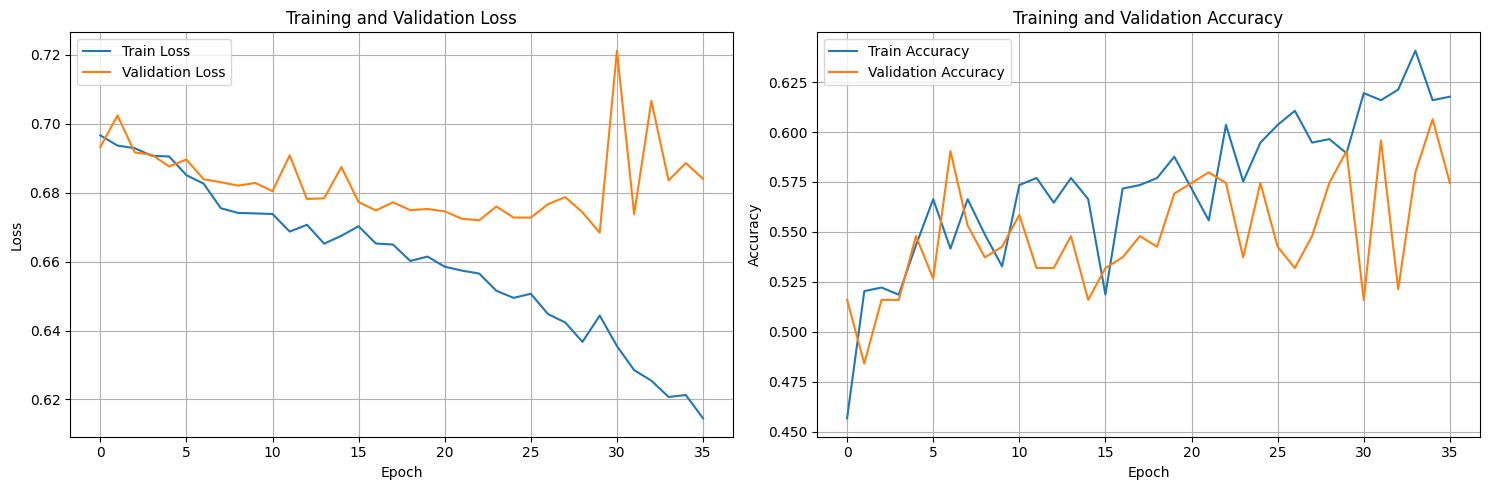

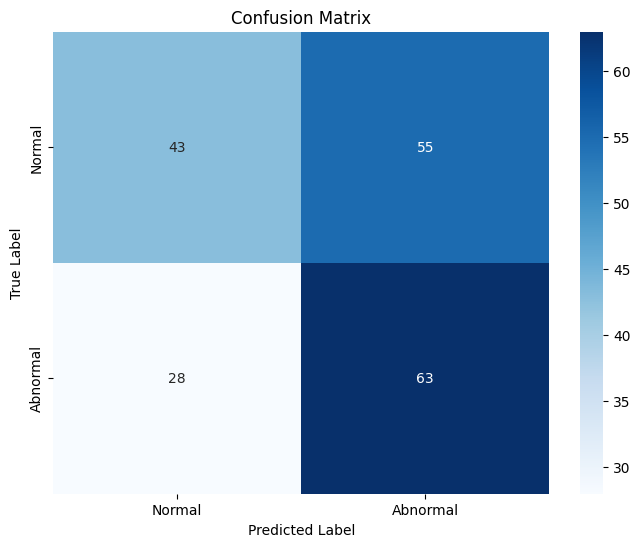

ModelVisualizer initialized with device: cuda
Validation loader: 6 batches
Caching 50 samples...
Cached 50 samples
Normal: 24, Abnormal: 26

QUICK VISUALIZATION COMMANDS:
# Attention weights:
viz.visualize_attention_weights([0,1,2,3,4,5])

# CNN features for specific sample/location:
viz.visualize_cnn_features(sample_idx=0, location='AV', layer_name='cnn_conv3')

# Compare features between classes:
normal_feat, abnormal_feat = viz.compare_features_by_class('cnn_output', 'AV')

# View input spectrograms:
viz.visualize_spectrograms([0,1,2,3])

# Available CNN layers: 'cnn_conv1', 'cnn_conv2', 'cnn_conv3', 'cnn_conv4', 'cnn_fc1', 'cnn_output'
Training completed successfully!
Model saved as 'best_heart_sound_model.pth'


In [ ]:
# Cell 7: Usage Example

# Example usage and training script
if __name__ == "__main__":
    # Set your data directory path here
    DATA_DIR = "C:\\Users\\Yosss\\Desktop\\the-circor-digiscope-phonocardiogram-dataset-1.0.3\\the-circor-digiscope-phonocardiogram-dataset-1.0.3\\training_data"
    
    # Check if directory exists (comment out if you want to skip this check)
    if not os.path.exists(DATA_DIR):
        print(f"Data directory {DATA_DIR} not found!")
        print("Please update DATA_DIR variable with the correct path to your CirCor dataset")
        print("\nTo use this code:")
        print("1. Download the CirCor dataset from PhysioNet")
        print("2. Extract it to a directory")
        print("3. Update the DATA_DIR variable above")
        print("4. Run the training pipeline")
        exit()
    
    # Run training pipeline
    try:
        trained_model, preprocessor, scaler, viz = main_training_pipeline(
            data_dir=DATA_DIR,
            batch_size=32,  # Adjust based on your GPU memory
            num_epochs=100,
            learning_rate=0.0001
        )
        
        print("Training completed successfully!")
        print("Model saved as 'best_heart_sound_model.pth'")
        

    except Exception as e:
        print(f"Error during training: {e}")
        import traceback
        traceback.print_exc()

In [2]:
#Example prediction (uncomment to use)

class HeartSoundDatasetPredict(Dataset):
    """Dataset class for heart sound classification"""
    
    def __init__(self, patients_data, preprocessor=None, demographic_scaler=None):
        self.patients_data = patients_data
        self.preprocessor = preprocessor if preprocessor else AudioPreprocessor()
        self.demographic_scaler = demographic_scaler
        self.locations = ['AV', 'PV', 'TV', 'MV']
        
    def __len__(self):
        return len(self.patients_data)

    def __getitem__(self, idx):
        patient = self.patients_data[idx]

        # Process audio for each location
        location_embeddings = {}
        
        for location in self.locations:
            if location in patient.get('recordings', {}):
                # Get all recordings for this location
                recording_files = patient['recordings'][location]
                
                all_clips_embeddings = []
                
                for audio_file in recording_files:
                    try:
                        # Load audio
                        audio, sr = librosa.load(audio_file, sr=self.preprocessor.sample_rate)
                        
                        # Split into 5-second clips
                        clips = self.preprocessor.split_into_5s_clips(audio, sr)
                        
                        # Process each clip
                        for clip in clips:
                            mel_spec = self.preprocessor.audio_to_melspec(clip)
                            # Convert to tensor and add channel dimension
                            mel_tensor = torch.FloatTensor(mel_spec).unsqueeze(0)
                            all_clips_embeddings.append(mel_tensor)
                            
                    except Exception as e:
                        print(f"Error processing {audio_file}: {e}")
                        continue
                
                if all_clips_embeddings:
                    # Stack all clips for this location
                    location_embeddings[location] = torch.stack(all_clips_embeddings)
                else:
                    # Create dummy tensor if no valid clips
                    location_embeddings[location] = torch.zeros(1, 1, self.preprocessor.n_mels, 
                                                              self.preprocessor.n_mels)
            else:
                # Create dummy tensor for missing location
                location_embeddings[location] = torch.zeros(1, 1, self.preprocessor.n_mels, 
                                                          self.preprocessor.n_mels)
        
        # Process demographics
        demographics = self.process_demographics(patient)

        return location_embeddings, demographics

    def process_demographics(self, patient):
        """Process demographic information into numerical features"""
        # Extract and encode demographic features
        features = []
        
        # Height (convert to float or use median if missing)
        try:
            height = float(patient.get('height', 120.0))  # median height in dataset
        except (ValueError, TypeError):
            height = 120.0
        features.append(height)
        
        # Weight (convert to float or use median if missing)
        try:
            weight = float(patient.get('weight', 25.0))  # median weight in dataset
        except (ValueError, TypeError):
            weight = 25.0
        features.append(weight)
        
        # Sex (0 for Female, 1 for Male)
        sex = 1 if patient.get('sex') == 'Male' else 0
        features.append(sex)
        
        # Age (encode age categories as numerical)
        age_mapping = {
            'Neonate': 0, 'Infant': 1, 'Child': 2, 
            'Adolescent': 3, 'Young Adult': 4
        }
        age = age_mapping.get(patient.get('age'), 2)  # default to Child
        features.append(age)
        
        # Pregnancy status (0 for False/None, 1 for True)
        pregnancy = 1 if patient.get('pregnancy_status') == 'True' else 0
        features.append(pregnancy)
        
        demographics_tensor = torch.FloatTensor(features)
        


        if self.demographic_scaler:
            features_np = np.array(features).reshape(1, -1)
            demographics_tensor = torch.FloatTensor(
                self.demographic_scaler.transform(features_np).flatten()
            )
        
        return demographics_tensor



def predict_single_patient(model, preprocessor, demographic_scaler, patient_data, device):
    """Make prediction for a single patient"""
    model.eval()
    
    # Create dataset with single patient
    dataset = HeartSoundDatasetPredict([patient_data], preprocessor, demographic_scaler)

    if len(dataset) == 0:
        return None, "No valid data for prediction"

    # Get data
    location_data, demographics, _ = dataset[0]

    # Add batch dimension and move to device
    demographics = demographics.unsqueeze(0).to(device)

    # Prepare location data
    batch_location_data = {}
    for loc in ['AV', 'PV', 'TV', 'MV']:
        batch_location_data[loc] = [location_data[loc].to(device)]

    with torch.no_grad():
        outputs = model(batch_location_data, demographics)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    prediction = "Normal" if predicted.item() == 0 else "Abnormal"
    confidence = probabilities[0][predicted.item()].item()

    return prediction, confidence





sample_patient = {
    'subject_id': '12345',
    'age': 'Child',
    'sex': 'Female', 
    'height': '120.0',
    'weight': '25.0',
    'pregnancy_status': 'False',
    'recordings': {
        'AV': ['C:\\Users\\Yosss\\Desktop\\the-circor-digiscope-phonocardiogram-dataset-1.0.3\\the-circor-digiscope-phonocardiogram-dataset-1.0.3\\training_data\\85349_AV.wav'],
        'PV': ['C:\\Users\\Yosss\\Desktop\\the-circor-digiscope-phonocardiogram-dataset-1.0.3\\the-circor-digiscope-phonocardiogram-dataset-1.0.3\\training_data\\85349_PV.wav'],
        'TV': ['C:\\Users\\Yosss\\Desktop\\the-circor-digiscope-phonocardiogram-dataset-1.0.3\\the-circor-digiscope-phonocardiogram-dataset-1.0.3\\training_data\\85349_TV.wav'],
        'MV': ['C:\\Users\\Yosss\\Desktop\\the-circor-digiscope-phonocardiogram-dataset-1.0.3\\the-circor-digiscope-phonocardiogram-dataset-1.0.3\\training_data\\85349_MV.wav'],
    }
}

prediction, confidence = predict_single_patient(
    trained_model, preprocessor, scaler, sample_patient, 
    torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)
print(confidence)


NameError: name 'Dataset' is not defined

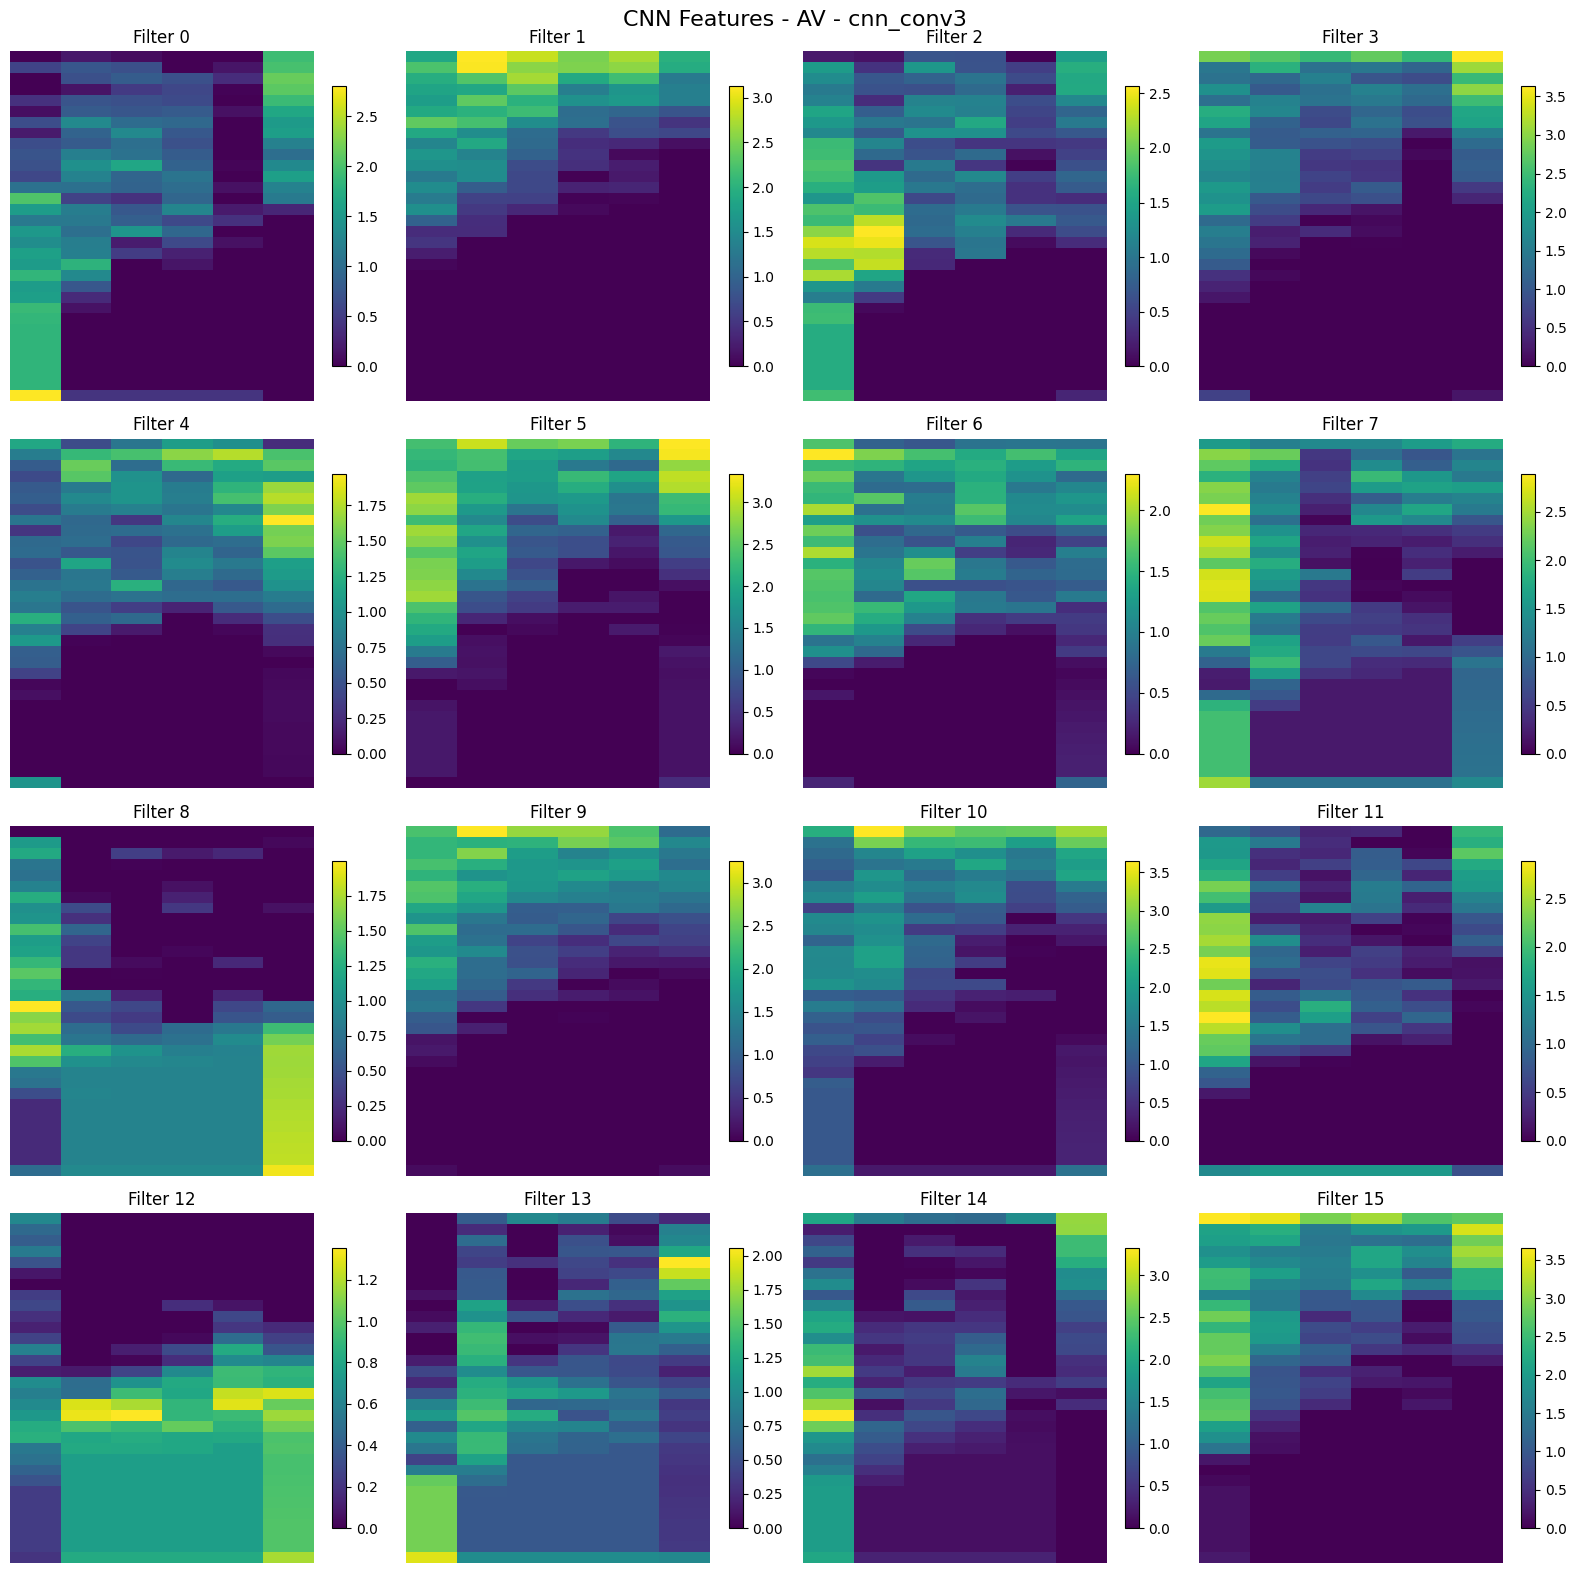

In [8]:
viz.visualize_cnn_features(sample_idx=0, location='AV', layer_name='cnn_conv3')